In [1]:
## Import necessary libraries

import kagglehub  # For loading datasets from Kaggle
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For data visualization
from sklearn.model_selection import train_test_split  # For splitting the data
from sklearn.preprocessing import StandardScaler  # For scaling features
from sklearn.ensemble import RandomForestRegressor  # For random forest regression
from sklearn.linear_model import LinearRegression  # For linear regression
from sklearn.tree import DecisionTreeRegressor  # For decision tree regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # For model evaluation
import xgboost as xgb  # For XGBoost model
import plotly.express as px  # For interactive plots
import joblib # For saving and loading models
import os  # For file operations
# Import the dataset from Kaggle - https://www.kaggle.com/datasets/matheusnbrega/preo-do-aluguel-de-imveis-no-distrito-federal

path = kagglehub.dataset_download("matheusnbrega/preo-do-aluguel-de-imveis-no-distrito-federal")




# Load the dataset
dataset = "imoveis-df.csv"

In [2]:
df = pd.read_csv(dataset, sep=";")

print(df.head())
print(df.info())

   preco         tipo area  quartos        bairro
0   1800  Apartamento   45        1       asa sul
1    600       Kitnet   30        1     asa norte
2   1200  Apartamento   37        1  aguas claras
3    600       Kitnet   25        1     asa norte
4   2600   Hotel-Flat   49        1       asa sul
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2871 entries, 0 to 2870
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   preco    2871 non-null   int64 
 1   tipo     2871 non-null   object
 2   area     2871 non-null   object
 3   quartos  2871 non-null   int64 
 4   bairro   2871 non-null   object
dtypes: int64(2), object(3)
memory usage: 112.3+ KB
None


In [3]:
# Data Cleaning
try:
    df['area'] = df['area'].str.replace(",", ".", regex=False)  # change comma to dot
    df['area'] = pd.to_numeric(df['area'], errors='coerce')  # convert to numeric, coercing errors to NaN
except Exception as e:
    print(f"Erro na conversão da coluna 'area': {e}")

# Remove Na values in 'area' and 'preco' columns
df = df.dropna(subset=['area', 'preco'])

# Feature engineering: create a new feature 'preco_m2' for price per square meter
df['preco_m2'] = df['preco'] / df['area']  # price per square meter

# Filter invalid values (outliers based on the area and price)
df_filtered = df[(df['preco'] <= 15000) & (df['area'] <= 400) & (df['preco'] > 50) & (df['area'] > 5)]

# Data description
print(df_filtered.dtypes)
print(df_filtered.describe())


preco         int64
tipo         object
area        float64
quartos       int64
bairro       object
preco_m2    float64
dtype: object
              preco         area      quartos     preco_m2
count   2610.000000  2610.000000  2610.000000  2610.000000
mean    1943.854406    65.404981     1.761686    33.240761
std     1762.733795    59.702568     1.195008    18.163419
min      100.000000    10.000000     1.000000     2.000000
25%      900.000000    30.000000     1.000000    21.034186
50%     1300.000000    45.000000     1.000000    30.317781
75%     2300.000000    70.000000     2.000000    40.000000
max    15000.000000   400.000000    33.000000   318.181818


In [4]:
# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df_filtered, columns=['tipo', 'bairro'], drop_first=True)

# Separation of features and target variable
X = df_encoded.drop(['preco', 'preco_m2'], axis=1)
y = df_encoded['preco']

# Applying standardization to the features
scaler = StandardScaler()

# selecting only numeric columns for scaling
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Adjusting the scaler to the numeric columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Check the features shape
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')


Features shape: (2610, 38)
Target shape: (2610,)


In [5]:
# Divide into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the distribution of the target variable in train and test sets
print(f"Distribuição da variável 'preco' no conjunto de treino: {y_train.describe()}")
print(f"Distribuição da variável 'preco' no conjunto de teste: {y_test.describe()}")

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


Distribuição da variável 'preco' no conjunto de treino: count     2088.000000
mean      1955.874521
std       1761.398123
min        100.000000
25%        900.000000
50%       1300.000000
75%       2340.000000
max      14000.000000
Name: preco, dtype: float64
Distribuição da variável 'preco' no conjunto de teste: count      522.000000
mean      1895.773946
std       1768.941670
min        200.000000
25%        900.000000
50%       1300.000000
75%       2200.000000
max      15000.000000
Name: preco, dtype: float64
X_train shape: (2088, 38)
X_test shape: (522, 38)
y_train shape: (2088,)
y_test shape: (522,)


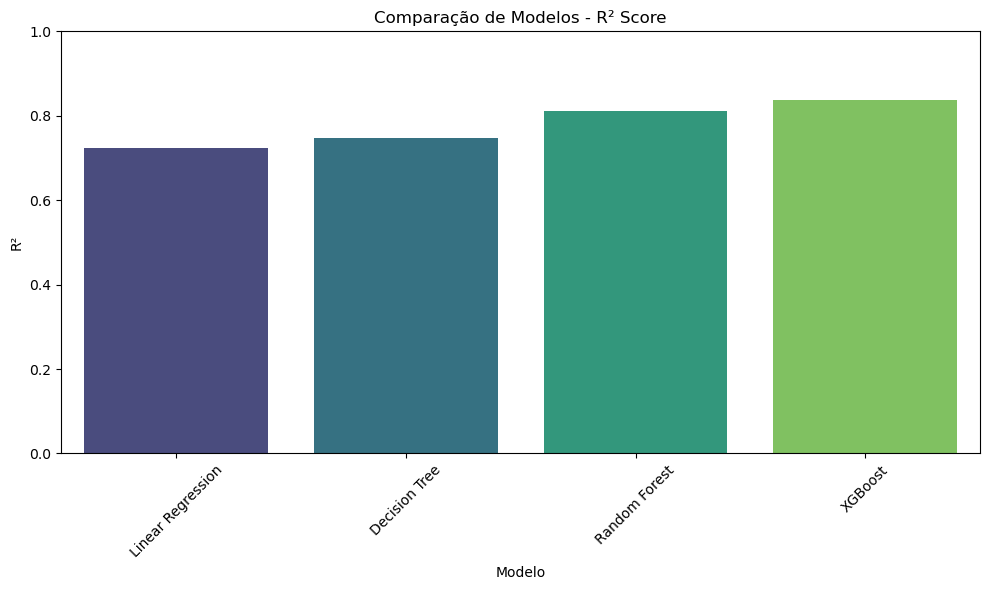

Linear Regression - MAE: 574.59, RMSE: 928.73, R²: 0.7238
Decision Tree - MAE: 473.54, RMSE: 887.86, R²: 0.7476
Random Forest - MAE: 421.82, RMSE: 766.43, R²: 0.8119
XGBoost - MAE: 400.45, RMSE: 712.41, R²: 0.8375


In [6]:
# Model training and evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

results = {}

# Train each model and evaluate
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

# Show the results in a more visual way
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Modelo'})
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Modelo', y='R²', palette='viridis')
plt.title('Comparação de Modelos - R² Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show individual results
for model_name, metrics in results.items():
    print(f"{model_name} - MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}, R²: {metrics['R²']:.4f}")


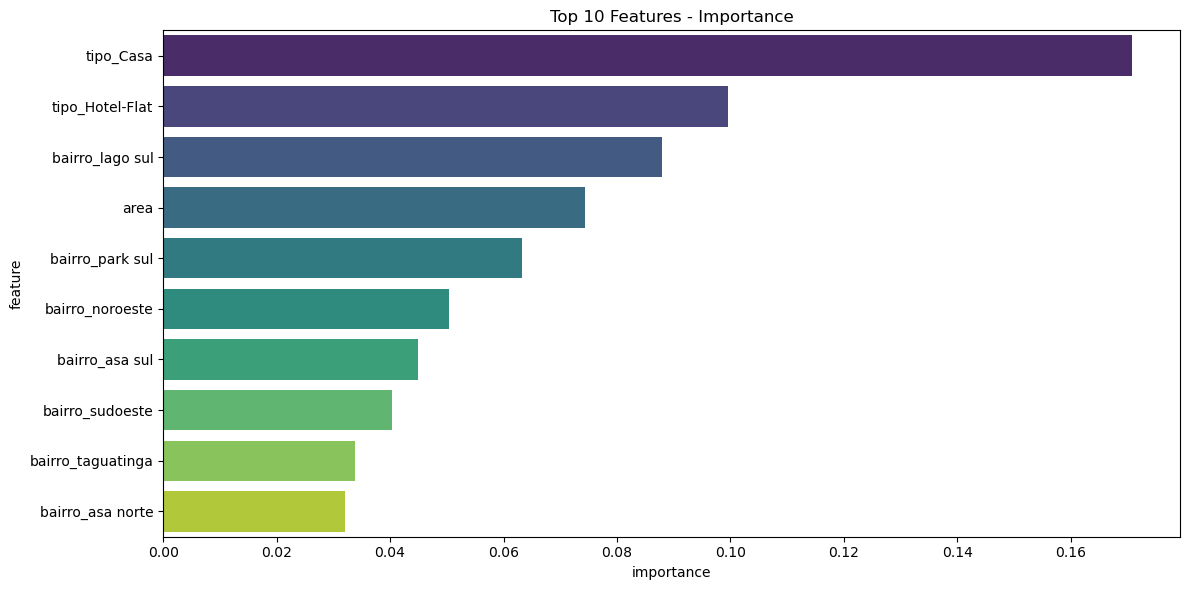

In [7]:
# Feature importance
importances = model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'feature': features, 'importance': importances})

# Sorting the features by importance
feature_df = feature_df.sort_values(by='importance', ascending=False)

# Show top 10 most important features
plt.figure(figsize=(12,6))
sns.barplot(data=feature_df.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 Features - Importance')
plt.tight_layout()
plt.show()


In [8]:

# Mean price per neighborhood
df_mapa = df_filtered.groupby("bairro").agg({"preco": "mean"}).reset_index()
fig = px.bar(df_mapa, x="bairro", y="preco", title="Preço médio por bairro", labels={"preco":"Preço Médio (R$)"})
fig.update_layout(xaxis_title="Bairros", yaxis_title="Preço Médio (R$)")
fig.show()


In [ ]:
# Create a directory to save the model and dataset
output_dir = "modelos_e_datasets"
os.makedirs(output_dir, exist_ok=True)

# Save the trained XGBoost model
modelo_path = os.path.join(output_dir, 'modelo_xgboost.pkl')
joblib.dump(models['XGBoost'], modelo_path)
print(f'Modelo XGBoost salvo em: {modelo_path}')

# Save final dataset
dataset_path = os.path.join(output_dir, 'brasilia-rent-price-prediction-df.csv')
df_filtered.to_csv(dataset_path, index=False)
print(f'Dataset final salvo em: {dataset_path}')

# Save the scaler
scaler_path = os.path.join(output_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)  # Salva o scaler no diretório
print(f'Scaler salvo em: {scaler_path}')

Modelo XGBoost salvo em: modelos_e_datasets\modelo_xgboost.pkl
Dataset final salvo em: modelos_e_datasets\dataset_final.csv
Scaler salvo em: modelos_e_datasets\scaler.pkl
